#### Preamble

In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

import numpy as np
from numpy import radians, degrees, cos, sin, tan, arcsin, arctan

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#### Loading in the dataset

In [2]:
dataset_path = "./galactic_data.txt"
column_names = ['RAJ2000','DEJ2000','f_RV','Distance','Error_Distance','W_Velocity'] 
raw_dataset = pd.read_csv(dataset_path, names= column_names, sep = ",")
dataset = raw_dataset.copy()
dataset.tail()

,RAJ2000,DEJ2000,f_RV,Distance,Error_Distance,W_Velocity
5676,359.439790,25.141479,*,134.4,12.3,-7.5
5677,359.579202,19.693546,*,364.2,64.4,-16.8
5678,359.603307,51.388763,*,137.3,19.5,4.3
5679,359.734255,4.273517,*,484.1,147.0,-26.4
5680,359.976057,5.956638,*,213.8,36.0,-23.2


In [3]:
f_RV = dataset.pop('f_RV')
dataset.tail()

,RAJ2000,DEJ2000,Distance,Error_Distance,W_Velocity
5676,359.439790,25.141479,134.4,12.3,-7.5
5677,359.579202,19.693546,364.2,64.4,-16.8
5678,359.603307,51.388763,137.3,19.5,4.3
5679,359.734255,4.273517,484.1,147.0,-26.4
5680,359.976057,5.956638,213.8,36.0,-23.2


#### Plotting the Right Ascension and Declination

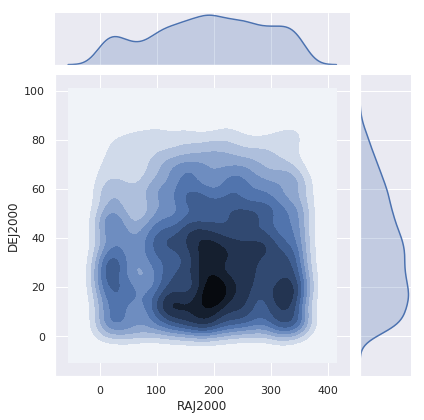

In [22]:
sns.set(color_codes=True)
sns.jointplot(x = "RAJ2000", y = "DEJ2000", data = dataset, kind = "kde");

#### Calculating the Galactic Coordinates 

In [5]:
def galactic_latitude(row):
    b = degrees(arcsin((cos(radians(row['DEJ2000']))*cos(radians(27.4))*cos(radians(row['RAJ2000']-192.25)))+(sin(radians(row['DEJ2000']))*sin(radians(27.4)))));
    return b
dataset['Galactic_Latitude'] = dataset.apply(galactic_latitude, axis = 'columns')

In [6]:
def galactic_longitude(row):
    l = degrees(arctan((sin(radians(row['DEJ2000']))-sin(radians(row['Galactic_Latitude'])))*sin(radians(27.4)))/(cos(radians(row['DEJ2000']))*sin(radians(row['RAJ2000']-192.25))*cos(radians(27.4))))+33
    return l
dataset['Galactic_Longitude'] = dataset.apply(galactic_longitude, axis = 'columns')

#### Calculating the Height Distribution

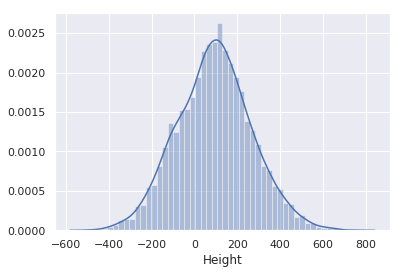

In [7]:
def height(row):
    h = sin(radians(row['Galactic_Latitude']))*row['Distance']
    return h
dataset['Height'] = dataset.apply(height, axis = 'columns');
sns.distplot(dataset.Height); 

In [8]:
dataset.tail()

,RAJ2000,DEJ2000,Distance,Error_Distance,W_Velocity,Galactic_Latitude,Galactic_Longitude,Height
5676,359.439790,25.141479,134.4,12.3,-7.5,-36.028145,173.263825,-79.051740
5677,359.579202,19.693546,364.2,64.4,-16.8,-41.333943,167.474865,-240.534657
5678,359.603307,51.388763,137.3,19.5,4.3,-10.427158,229.937170,-24.849286
5679,359.734255,4.273517,484.1,147.0,-26.4,-56.100274,150.794707,-401.810238
5680,359.976057,5.956638,213.8,36.0,-23.2,-54.595316,155.105615,-174.264197


#### Machine learning 

In [9]:
train_dataset = dataset.sample(frac = 0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

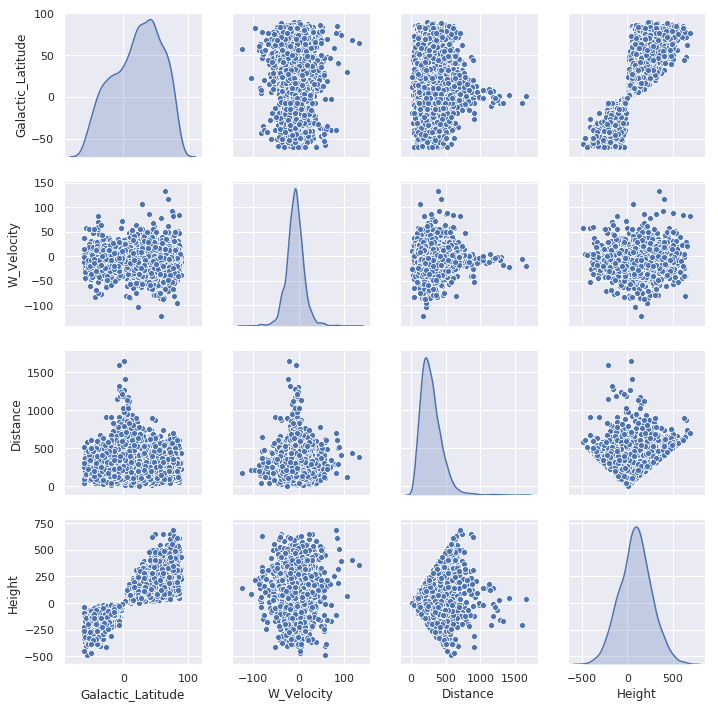

In [10]:
sns.pairplot(train_dataset[["Galactic_Latitude", "W_Velocity", "Distance", "Height"]], diag_kind="kde")

In [11]:
train_stats = dataset.describe()
train_stats.pop("Height")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
RAJ2000,5681.0,191.589880,98.151872,0.066236,119.199572,195.658165,270.835719,359.976057
DEJ2000,5681.0,34.156814,21.012026,1.002684,16.664373,32.145491,49.526236,89.037715
Distance,5681.0,291.656082,155.556787,10.400000,183.800000,266.100000,368.700000,1654.500000
Error_Distance,5681.0,60.354761,56.066593,0.100000,23.000000,45.900000,82.000000,809.900000
W_Velocity,5681.0,-7.742440,19.503243,-157.200000,-18.300000,-7.600000,3.000000,132.200000
Galactic_Latitude,5681.0,21.896975,36.327089,-61.381083,-6.594592,25.903030,50.637459,89.637952
Galactic_Longitude,5681.0,-16.532222,4041.983443,-233104.716519,8.263875,37.370041,66.788340,104118.286400


In [12]:
train_labels = train_dataset.pop('Height')
test_labels = test_dataset.pop('Height')

In [13]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [28]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation = tf.nn.relu, input_shape = [len(train_dataset.keys())]),
    layers.Dense(64, activation = tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss = 'mean_squared_error', optimizer = optimizer,
                metrics = ['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(normed_train_data, train_labels, epochs = 300, validation_split = 0.2, verbose = 0)

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
295,5.623966,1.432253,5.623967,26.632054,1.433603,26.632053,295
296,6.155764,1.404756,6.155764,26.981280,1.660172,26.981285,296
297,6.196467,1.365511,6.196467,23.927024,1.582233,23.927027,297
298,5.295515,1.394049,5.295516,27.291980,1.443977,27.291981,298
299,5.494293,1.388918,5.494293,24.615246,1.593320,24.615246,299


#### Checking the predictions

In [17]:
test_predictions = model.predict(normed_test_data)

In [18]:
reg = pd.DataFrame(test_predictions, columns = ["Predictions"]) 

In [19]:
reg["True Values"] = pd.DataFrame(test_labels.values)  

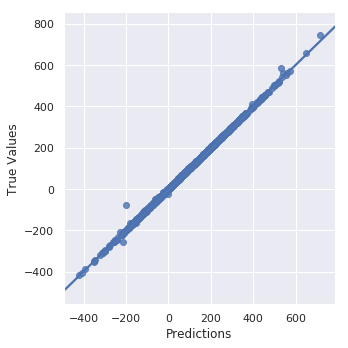

In [23]:
sns.lmplot(x = "Predictions", y = "True Values", data = reg);